In [31]:

from IPython.display import Markdown, display

import pandas as pd
import numpy as np
np.random.seed(42)
rng = np.random.default_rng(42)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from pathlib import Path
data_path = Path('./data')
data_dir = data_path / 'train_images'


import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

torch.manual_seed(2024)

## Load Data

In [54]:
df_test = pd.read_csv(data_path / "testlabels.csv")
df_test["base_path"] = data_path / "leaderboard_test_data"
df_test["image_id"] = df_test.image_id.str[:9].astype(str) + ".jpg"

df_test

,image_id,has_oilpalm,score,base_path
0,img_04925.jpg,0,1.0000,data/leaderboard_test_data
1,img_04817.jpg,1,1.0000,data/leaderboard_test_data
2,img_10358.jpg,0,1.0000,data/leaderboard_test_data
3,img_06729.jpg,0,0.6000,data/leaderboard_test_data
4,img_09008.jpg,0,1.0000,data/leaderboard_test_data
...,...,...,...,...
4351,img_08321.jpg,0,1.0000,data/leaderboard_test_data
4352,img_09266.jpg,0,1.0000,data/leaderboard_test_data
4353,img_09829.jpg,0,0.8087,data/leaderboard_test_data
4354,img_08499.jpg,0,1.0000,data/leaderboard_test_data


<Axes: xlabel='has_oilpalm', ylabel='count'>

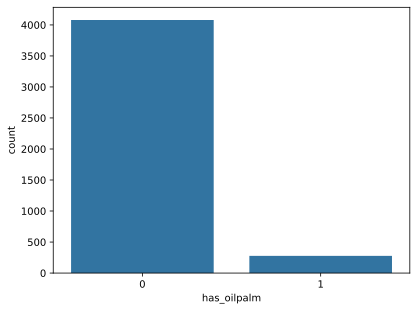

In [33]:
sns.countplot(df_test, x="has_oilpalm")

In [43]:
df_holdout = pd.read_csv(data_path / "holdout.csv")
df_holdout["base_path"] = data_path / "leaderboard_holdout_data"
df_holdout

,image_id,has_oilpalm,score,base_path
0,img_050982017.jpg,1,1.0000,data/leaderboard_holdout_data
1,img_101882017.jpg,1,1.0000,data/leaderboard_holdout_data
2,img_109452017.jpg,1,0.8079,data/leaderboard_holdout_data
3,img_009842017.jpg,1,1.0000,data/leaderboard_holdout_data
4,img_083672017.jpg,1,1.0000,data/leaderboard_holdout_data
...,...,...,...,...
2173,img_012452018.jpg,0,1.0000,data/leaderboard_holdout_data
2174,img_078482018.jpg,0,1.0000,data/leaderboard_holdout_data
2175,img_074352018.jpg,0,1.0000,data/leaderboard_holdout_data
2176,img_087262018.jpg,0,1.0000,data/leaderboard_holdout_data


<Axes: xlabel='has_oilpalm', ylabel='count'>

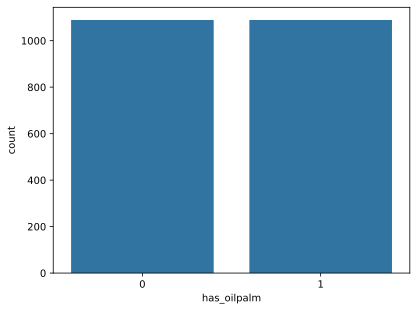

In [35]:
sns.countplot(df_holdout, x="has_oilpalm")

PosixPath('data/train_images')

In [36]:
# sourcery skip: use-fstring-for-concatenation
df = pd.read_csv(data_path / "traininglabels.csv")
df["image_id"] = df.image_id.str[:9].astype(str) + ".jpg"
df['base_path'] = data_path / 'train_images'
df = df.iloc[:11000]  # limit to 11000 rows for now since the rest are missing

df

,image_id,has_oilpalm,score
0,img_00000.jpg,0,0.7895
1,img_00001.jpg,0,1.0000
2,img_00002.jpg,0,1.0000
3,img_00007.jpg,0,1.0000
4,img_00008.jpg,0,1.0000
...,...,...,...
10995,img_05081.jpg,0,1.0000
10996,img_05082.jpg,0,1.0000
10997,img_05084.jpg,0,1.0000
10998,img_05085.jpg,1,1.0000


In [55]:
# check for missing images


def drop_missing_images(df):
    for index, row in df.iterrows():
        if not os.path.exists(row.base_path / row.image_id):
            print(f"dropping: {row.image_id}")
            df.drop(index, inplace=True)

    return df


df_test = drop_missing_images(df_test)

dropping: img_10358.jpg
dropping: img_09691.jpg
dropping: img_09229.jpg
dropping: img_10991.jpg
dropping: img_09066.jpg
dropping: img_09476.jpg
dropping: img_10766.jpg
dropping: img_10278.jpg
dropping: img_09377.jpg
dropping: img_09025.jpg
dropping: img_10836.jpg
dropping: img_09650.jpg
dropping: img_10086.jpg
dropping: img_10175.jpg
dropping: img_09847.jpg
dropping: img_10916.jpg
dropping: img_09673.jpg
dropping: img_10633.jpg
dropping: img_10118.jpg
dropping: img_09952.jpg
dropping: img_09281.jpg
dropping: img_10611.jpg
dropping: img_10613.jpg
dropping: img_09760.jpg
dropping: img_10698.jpg
dropping: img_09331.jpg
dropping: img_10280.jpg
dropping: img_09614.jpg
dropping: img_10244.jpg
dropping: img_10614.jpg
dropping: img_09069.jpg
dropping: img_09314.jpg
dropping: img_10937.jpg
dropping: img_09037.jpg
dropping: img_09792.jpg
dropping: img_10875.jpg
dropping: img_09106.jpg
dropping: img_09730.jpg
dropping: img_09913.jpg
dropping: img_10845.jpg
dropping: img_09263.jpg
dropping: img_09

In [56]:
df_test

,image_id,has_oilpalm,score,base_path
0,img_04925.jpg,0,1.0,data/leaderboard_test_data
1,img_04817.jpg,1,1.0,data/leaderboard_test_data
3,img_06729.jpg,0,0.6,data/leaderboard_test_data
4,img_09008.jpg,0,1.0,data/leaderboard_test_data
5,img_05650.jpg,0,1.0,data/leaderboard_test_data
...,...,...,...,...
4347,img_04701.jpg,0,1.0,data/leaderboard_test_data
4350,img_01705.jpg,0,1.0,data/leaderboard_test_data
4351,img_08321.jpg,0,1.0,data/leaderboard_test_data
4354,img_08499.jpg,0,1.0,data/leaderboard_test_data


In [38]:
df["has_oilpalm"].value_counts()

has_oilpalm
0    10316
1      684
Name: count, dtype: int64

In [39]:
df.query("score >= 0.8")["has_oilpalm"].value_counts()

has_oilpalm
0    9414
1     586
Name: count, dtype: int64

In [40]:
df = df.query("score == 1")

## Highly Imbalanced

<Axes: xlabel='has_oilpalm', ylabel='count'>

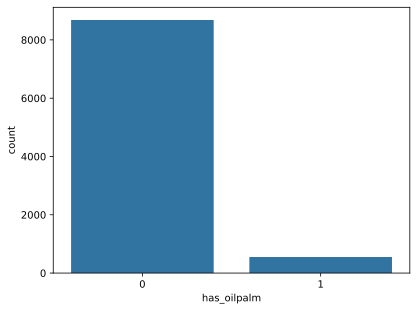

In [7]:
sns.countplot(data=df, x="has_oilpalm")

In [8]:
df0 = df.query("has_oilpalm == 0")
df1 = df.query("has_oilpalm == 1")

In [9]:
df1 = df1.sample(len(df0), random_state=42, replace=True)
df1

,image_id,has_oilpalm,score
2048,img_02969.jpg,1,1.0
8653,img_01668.jpg,1,1.0
5393,img_07878.jpg,1,1.0
2081,img_03015.jpg,1,1.0
1634,img_02357.jpg,1,1.0
...,...,...,...
5084,img_07392.jpg,1,1.0
9687,img_03190.jpg,1,1.0
10241,img_03990.jpg,1,1.0
8811,img_01902.jpg,1,1.0


In [10]:
# concatenate the two dataframes
df = pd.concat([df0, df1], ignore_index=True)
df

,image_id,has_oilpalm,score
0,img_00001.jpg,0,1.0
1,img_00002.jpg,0,1.0
2,img_00007.jpg,0,1.0
3,img_00008.jpg,0,1.0
4,img_00009.jpg,0,1.0
...,...,...,...
17359,img_07392.jpg,1,1.0
17360,img_03190.jpg,1,1.0
17361,img_03990.jpg,1,1.0
17362,img_01902.jpg,1,1.0


<Axes: xlabel='has_oilpalm', ylabel='count'>

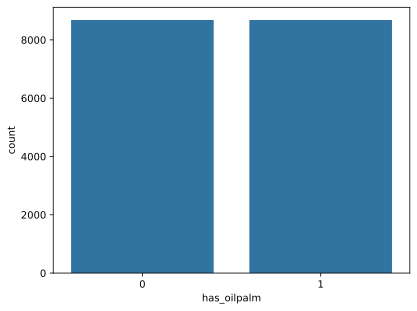

In [11]:
sns.countplot(data=df, x="has_oilpalm")

2257

### Note that calculating these weights on the entire dataset is peeking into the future!  Bad practice!

In [12]:
weight0 = len(df) / df.has_oilpalm.value_counts()[0]
weight1 = len(df) / df.has_oilpalm.value_counts()[1]

weight0, weight1

(np.float64(2.0), np.float64(2.0))

In [13]:
df["weights"] = df.has_oilpalm.map({0: weight0, 1: weight1})
df

,image_id,has_oilpalm,score,weights
0,img_00001.jpg,0,1.0,2.0
1,img_00002.jpg,0,1.0,2.0
2,img_00007.jpg,0,1.0,2.0
3,img_00008.jpg,0,1.0,2.0
4,img_00009.jpg,0,1.0,2.0
...,...,...,...,...
17359,img_07392.jpg,1,1.0,2.0
17360,img_03190.jpg,1,1.0,2.0
17361,img_03990.jpg,1,1.0,2.0
17362,img_01902.jpg,1,1.0,2.0


## Data Augmentation

In [14]:
train_transform = transforms.Compose(
    [
        # transforms.Resize((232, 232)),
        v2.RandomResizedCrop((232, 232)),
        v2.RandomHorizontalFlip(),
        v2.RandomRotation(degrees=15),
        v2.RandomAutocontrast(),
        # v2.RandomAugment(),
        v2.AutoAugment(),
        transforms.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


val_transform = transforms.Compose(
    [
        v2.Resize((232, 232)),
        transforms.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

## Define the dataset class

In [15]:
class CustomDataset(Dataset):
    def __init__(
        self,
        data_frame,
        root_dir,
        train_transform=None,
        val_transform=None,
        validation=True,
    ):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.train_transform = train_transform
        self.val_transform = val_transform
        self.validation = validation

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.loc[idx, "image_id"])
        image = Image.open(img_name).convert("RGB")
        label = torch.tensor(self.data_frame.loc[idx, "has_oilpalm"])

        if self.val_transform and self.validation:
            image = self.val_transform(image)
        elif self.train_transform:
            image = self.train_transform(image)

        # weight = self.data_frame.loc[idx, "weights"]

        return image, label  # , weight

## Split the data and create the dataloaders

In [16]:
dataset = CustomDataset(
    data_frame=df,
    root_dir=data_dir,
    train_transform=train_transform,
    val_transform=val_transform,
)

train_size = int(0.74 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = (len(dataset) - train_size) // 2


# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
#     dataset, [train_size, val_size, test_size]
# )

# Stratified Sampling for train and val
train_idx, val_idx = train_test_split(
    np.arange(len(df)),
    test_size=0.13,
    random_state=999,
    shuffle=True,
    stratify=df.has_oilpalm,
)

_df = df[df.index.isin(train_idx)]

train_idx, test_idx = train_test_split(
    np.arange(len(_df)),
    test_size=0.14,
    random_state=999,
    shuffle=True,
    stratify=_df.has_oilpalm,
)

# Subset dataset for train and val
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_dataset.dataset.validation = False


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## define the model

In [17]:
# num_classes = len(
#     dataset.data_frame.iloc[:, 1].unique()
# )  # Assuming labels are categorical

num_classes = 1

model = models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V2")
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 32), nn.ReLU(), nn.Linear(32, num_classes)
)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight1], device=device))
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.000001, weight_decay=0.0001)

## Utility functions to save and load the model

In [19]:
model_dir = Path("models/resnet50")


def checkpoint(model, filename):
    torch.save(model.state_dict(), model_dir / filename)


def resume(model, filename):
    model.load_state_dict(torch.load(model_dir / filename))

## Training Loop with Concurrent Validation, Early Stopping and Model Checkpointing

In [20]:
num_epochs = 100
sigmoid = nn.Sigmoid()
best_val_loss = None
best_val_score = None
best_epoch = 0
early_stop_threshold = 10
train_losses = []
val_losses = []
val_scores = []

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    val_loss = 0.0

    for images, labels in train_loader:
        images, labels = (
            images.to(device),
            labels.to(device),
        )

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(
            outputs.squeeze(),
            labels.float(),
        )
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation using roc_auc_score
    model.eval()
    val_preds = []
    val_true = []
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        val_loss += criterion(outputs.squeeze(), labels.float()).item()

        preds = sigmoid(outputs)
        # _, preds = torch.max(outputs.data, 1)
        val_preds.extend(preds.cpu().detach().numpy())
        val_true.extend(labels.cpu().detach().numpy())

    val_loss /= len(val_loader)
    running_loss /= len(train_loader)

    val_preds = np.array(val_preds)
    val_true = np.array(val_true)
    val_score = roc_auc_score(val_true, val_preds)

    # save the losses
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_scores.append(val_score)

    # checkpoint model if val_score is better
    if best_val_score is None or val_score >= best_val_score:
        best_val_score = val_score
        best_val_loss = val_loss
        best_epoch = epoch
        checkpoint(
            model,
            f"best_model epoch_{epoch} vloss_{val_loss:.4f} auc_{val_score:.4f} S.pth",
        )
        print(f"Model saved at epoch {epoch} (score)")
    # also checkpoint if val_loss is lower
    elif val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        checkpoint(
            model,
            f"best_model epoch_{epoch} vloss_{val_loss:.4f} auc_{val_score:.4f} L.pth",
        )
        print(f"Model saved at epoch {epoch} (loss)")

    print(
        f"Epoch [{epoch}/{num_epochs}], Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val ROC AUC: {val_score:.4f}"
    )

    # Early stopping
    if epoch - best_epoch >= early_stop_threshold:
        print(f"Early stopping at epoch {epoch+1}")
        checkpoint(
            model,
            f"stop_model epoch_{epoch} vloss_{val_loss:.4f} auc_{val_score:.4f}.pth",
        )
        break

Model saved at epoch 1
Epoch [1/100], Loss: 0.6873, Val Loss: 0.6821, Val ROC AUC: 0.7282
Model saved at epoch 2
Epoch [2/100], Loss: 0.6621, Val Loss: 0.6557, Val ROC AUC: 0.8194
Model saved at epoch 3
Epoch [3/100], Loss: 0.6269, Val Loss: 0.6288, Val ROC AUC: 0.8269
Model saved at epoch 4
Epoch [4/100], Loss: 0.5941, Val Loss: 0.6008, Val ROC AUC: 0.8396
Model saved at epoch 5
Epoch [5/100], Loss: 0.5679, Val Loss: 0.5862, Val ROC AUC: 0.8331
Model saved at epoch 6
Epoch [6/100], Loss: 0.5458, Val Loss: 0.5583, Val ROC AUC: 0.8417
Model saved at epoch 7
Epoch [7/100], Loss: 0.5240, Val Loss: 0.5300, Val ROC AUC: 0.8474
Model saved at epoch 8
Epoch [8/100], Loss: 0.5012, Val Loss: 0.5074, Val ROC AUC: 0.8490
Model saved at epoch 9
Epoch [9/100], Loss: 0.4786, Val Loss: 0.4904, Val ROC AUC: 0.8420


KeyboardInterrupt: 

In [ ]:
plt.plot(range(1, epoch + 1), train_losses, label="Train Loss")
plt.plot(range(1, epoch + 1), val_losses, label="Validation Loss")
plt.title("Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (10,) and (9,)

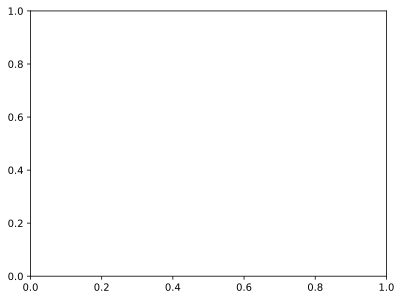

In [21]:
plt.plot(range(1, epoch + 1), val_scores, label="Validation ROC AUC")
plt.title("Validation ROC AUC")
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.legend()
plt.show()

## Load the best model and make predictions on the test set

### Early Stopped model

In [22]:
# resume(model, f"best_model epoch_{best_epoch} auc_{best_val_score}.pth")
# resume(model, f"resnet50/early stop epoch_8 auc_0.8413.pth")
sigmoid = nn.Sigmoid()

model.eval()
correct = 0
total = 0
labels_list = []
outputs_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = model(images)
        # _, predicted = torch.max(outputs.data, 1)
        preds = sigmoid(outputs)
        total += labels.size(0)
        correct += ((outputs.squeeze() > 0) == labels).sum().item()

        labels_list.append(labels.cpu().numpy())
        outputs_list.append(preds.cpu().numpy())

auc = roc_auc_score(np.concatenate(labels_list), np.concatenate(outputs_list))

print(f"Test Accuracy: {100 * correct / total:.2f}%")
print(f"Test AUC:      {auc:.4f}")

Test Accuracy: 84.63%
Test AUC:      0.8694


### Best Validation Loss Model

In [ ]:
resume(model, f"best_model epoch_{best_epoch} auc_{best_val_score:.4f}.pth")

model.eval()
correct = 0
total = 0
labels_list = []
outputs_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = model(images)
        # _, predicted = torch.max(outputs.data, 1)
        preds = sigmoid(outputs)
        total += labels.size(0)
        correct += ((outputs.squeeze() > 0) == labels).sum().item()

        labels_list.append(labels.cpu().numpy())
        outputs_list.append(preds.cpu().numpy())

auc = roc_auc_score(np.concatenate(labels_list), np.concatenate(outputs_list))

print(f"Test Accuracy: {100 * correct / total:.2f}%")
print(f"Test AUC:      {auc:.4f}")

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(
    np.concatenate(labels_list), np.concatenate(outputs_list) > 0.5
)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()